# RFM Customer Segmentation - Complete Analysis

**Portfolio Project:** ML-driven customer segmentation combining rule-based RFM methodology with unsupervised K-Means clustering.

**Author:** Lee Christian Lesemann  
**Dataset:** UCI Machine Learning Repository - Online Retail  
**Period:** Dec 2010 - Dec 2011 (388,724 cleaned transactions)  
**Objective:** Identify high-value customer segments and actionable marketing strategies

---

## Project Overview

This notebook demonstrates:
1. RFM (Recency, Frequency, Monetary) calculation and scoring
2. Rule-based customer segmentation (10 business segments)
3. K-Means clustering for validation and outlier detection
4. Comparative analysis and business insights

**Key Achievement:** Identified £548k at-risk revenue and 8 Super-VIP customers (£72k avg. spend)

---

## 1. Setup & Data Loading

Import libraries and load pre-cleaned dataset from notebook 01.

**Note:** Data cleaning was performed in `01_data_exploration.ipynb`
- Original: 541,909 transactions
- Cleaned: 388,724 transactions (72% retention)
- Removed: Missing CustomerIDs, cancelled orders, outliers

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

df_clean = pd.read_csv('../data/processed/online_retail_clean.csv')
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])

print(f"✅ Daten geladen: {df_clean.shape[0]:,} Zeilen")
print(f"👥 Unique Customers: {df_clean['CustomerID'].nunique():,}")

✅ Daten geladen: 388,724 Zeilen
👥 Unique Customers: 4,290


## 2. RFM Calculation

Calculate the three core customer value metrics:

**Recency (R):** Days since last purchase  
- Lower = Better (recently active)
- Reference date: 1 day after last transaction (2011-12-10)

**Frequency (F):** Number of unique transactions  
- Higher = Better (repeat customer)

**Monetary (M):** Total customer spend  
- Higher = Better (revenue contribution)

These metrics form the foundation of customer segmentation.


In [2]:
# RFM BERECHNUNG
print("🧮 BERECHNE RFM-SCORES")
print("=" * 60)

# Referenzdatum: 1 Tag nach letzter Transaktion
# (In der Praxis: "heute")
reference_date = df_clean['InvoiceDate'].max() + timedelta(days=1)
print(f"📅 Referenzdatum (Analyse-Datum): {reference_date.date()}")

# RFM für jeden Customer berechnen
rfm = df_clean.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                     # Frequency
    'TotalAmount': 'sum'                                        # Monetary
}).reset_index()

# Spalten umbenennen
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

print(f"\n✅ RFM berechnet für {len(rfm):,} Customers")
print("\n📊 RFM Statistiken:")
print(rfm.describe())

🧮 BERECHNE RFM-SCORES
📅 Referenzdatum (Analyse-Datum): 2011-12-10

✅ RFM berechnet für 4,290 Customers

📊 RFM Statistiken:
         CustomerID      Recency    Frequency       Monetary
count   4290.000000  4290.000000  4290.000000    4290.000000
mean   15294.258974    92.382517     4.200000    1564.827262
std     1720.766627    99.963718     7.474935    4453.156955
min    12347.000000     1.000000     1.000000       2.900000
25%    13810.250000    18.000000     1.000000     293.617500
50%    15287.500000    51.000000     2.000000     645.975000
75%    16774.750000   142.000000     5.000000    1555.335000
max    18287.000000   374.000000   207.000000  149101.280000


## 3. Data Exploration - High-Value Customers

Identify top customers across different dimensions before scoring.

In [3]:
# Erste RFM-Werte anschauen
print("\n🔍 Top 10 Customers nach Monetary Value:")
print(rfm.nlargest(10, 'Monetary')[['CustomerID', 'Recency', 'Frequency', 'Monetary']])

print("\n🔍 Top 10 Customers nach Frequency:")
print(rfm.nlargest(10, 'Frequency')[['CustomerID', 'Recency', 'Frequency', 'Monetary']])

print("\n🔍 10 aktivste Customers (niedrigste Recency):")
print(rfm.nsmallest(10, 'Recency')[['CustomerID', 'Recency', 'Frequency', 'Monetary']])


🔍 Top 10 Customers nach Monetary Value:
      CustomerID  Recency  Frequency   Monetary
1677     14646.0        2         65  149101.28
1867     14911.0        1        199  129954.15
3733     17511.0        3         30   70109.31
2160     15311.0        1         91   56566.47
557      13089.0        3         94   53488.24
1323     14156.0       10         53   52681.47
1280     14096.0        4         17   52255.30
1424     14298.0        8         42   49817.95
54       12415.0       25         15   44498.59
987      13694.0        4         47   44035.83

🔍 Top 10 Customers nach Frequency:
      CustomerID  Recency  Frequency   Monetary
325      12748.0        1        207   30388.41
1867     14911.0        1        199  129954.15
3970     17841.0        2        124   39529.84
557      13089.0        3         94   53488.24
1649     14606.0        1         93   12076.15
2160     15311.0        1         91   56566.47
477      12971.0        4         85   10554.76
1677     14

## 4. RFM Scoring & Quintile Analysis

Convert raw RFM values into standardized scores (1-5 scale) using quintile-based binning.

**Scoring Logic:**
- **R_Score:** 5 = most recent (top 20%), 1 = least recent (bottom 20%)
- **F_Score:** 5 = highest frequency, 1 = lowest frequency  
- **M_Score:** 5 = highest spend, 1 = lowest spend

**Why Quintiles?**
- Relative benchmarking (top 20% of YOUR customers)
- Handles skewed distributions
- Business-friendly interpretation

**Note:** Using `rank(method='first')` to handle duplicate values in quintile binning.

In [7]:
# RFM SCORING mit Quintilen
print("BERECHNE RFM-SCORES (1-5)")
print("=" * 60)

# Quintile berechnen (5 = Best, 1 = Worst)
try:
    rfm['R_Score'] = pd.qcut(rfm['Recency'], q=5, labels=[5, 4, 3, 2, 1], duplicates='drop')
except ValueError:
    rfm['R_Score'] = pd.qcut(rfm['Recency'], q=4, labels=[4, 3, 2, 1], duplicates='drop')
    
try:
    rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), q=5, labels=[1, 2, 3, 4, 5])
except ValueError:
    rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), q=4, labels=[1, 2, 3, 4])

try:
    rfm['M_Score'] = pd.qcut(rfm['Monetary'].rank(method='first'), q=5, labels=[1, 2, 3, 4, 5])
except ValueError:
    rfm['M_Score'] = pd.qcut(rfm['Monetary'].rank(method='first'), q=4, labels=[1, 2, 3, 4])

# Scores in Integer konvertieren
rfm['R_Score'] = rfm['R_Score'].astype(int)
rfm['F_Score'] = rfm['F_Score'].astype(int)
rfm['M_Score'] = rfm['M_Score'].astype(int)

# RFM_Score kombinieren
rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

# Gesamtscore
rfm['RFM_Total'] = rfm['R_Score'] + rfm['F_Score'] + rfm['M_Score']

print("RFM-Scores berechnet!")
print("\nScore-Verteilung:")
print(f"R_Score: Min={rfm['R_Score'].min()}, Max={rfm['R_Score'].max()}, Durchschnitt={rfm['R_Score'].mean():.2f}")
print(f"F_Score: Min={rfm['F_Score'].min()}, Max={rfm['F_Score'].max()}, Durchschnitt={rfm['F_Score'].mean():.2f}")
print(f"M_Score: Min={rfm['M_Score'].min()}, Max={rfm['M_Score'].max()}, Durchschnitt={rfm['M_Score'].mean():.2f}")

print("\nTop 10 nach RFM_Total:")
print(rfm.nlargest(10, 'RFM_Total')[['CustomerID', 'Recency', 'Frequency', 'Monetary', 'R_Score', 'F_Score', 'M_Score', 'RFM_Score', 'RFM_Total']])

BERECHNE RFM-SCORES (1-5)
RFM-Scores berechnet!

Score-Verteilung:
R_Score: Min=1, Max=5, Durchschnitt=3.01
F_Score: Min=1, Max=5, Durchschnitt=3.00
M_Score: Min=1, Max=5, Durchschnitt=3.00

Top 10 nach RFM_Total:
     CustomerID  Recency  Frequency  Monetary  R_Score  F_Score  M_Score  \
0       12347.0        2          7   4060.40        5        5        5   
14      12362.0        3         10   5226.23        5        5        5   
55      12417.0        3          9   3649.10        5        5        5   
70      12433.0        1          7  12968.83        5        5        5   
74      12437.0        2         18   4951.41        5        5        5   
99      12471.0        2         28  14285.05        5        5        5   
114     12490.0        5         10   5417.93        5        5        5   
142     12524.0        9          8   4485.72        5        5        5   
145     12528.0        9          6   1933.48        5        5        5   
164     12553.0        8  

In [8]:
# Cut-Points für jedes Quintil anzeigen
print("📏 QUINTIL CUT-POINTS (Grenzen zwischen Gruppen)")
print("=" * 60)

print("\n🔴 RECENCY (Tage seit letztem Kauf):")
print("   Score 5 (Beste 20%):  ", rfm[rfm['R_Score']==5]['Recency'].max(), "Tage oder weniger")
print("   Score 4:              ", rfm[rfm['R_Score']==4]['Recency'].max(), "Tage oder weniger")
print("   Score 3:              ", rfm[rfm['R_Score']==3]['Recency'].max(), "Tage oder weniger")
print("   Score 2:              ", rfm[rfm['R_Score']==2]['Recency'].max(), "Tage oder weniger")
print("   Score 1 (Schlechteste):", rfm[rfm['R_Score']==1]['Recency'].max(), "Tage")

print("\n🔵 FREQUENCY (Anzahl Käufe):")
print("   Score 1 (Niedrigste): ", rfm[rfm['F_Score']==1]['Frequency'].max(), "Käufe oder weniger")
print("   Score 2:              ", rfm[rfm['F_Score']==2]['Frequency'].max(), "Käufe oder weniger")
print("   Score 3:              ", rfm[rfm['F_Score']==3]['Frequency'].max(), "Käufe oder weniger")
print("   Score 4:              ", rfm[rfm['F_Score']==4]['Frequency'].max(), "Käufe oder weniger")
print("   Score 5 (Höchste):    ", rfm[rfm['F_Score']==5]['Frequency'].max(), "Käufe")

print("\n🟢 MONETARY (Customer Lifetime Value):")
print("   Score 1 (Niedrigster):", f"£{rfm[rfm['M_Score']==1]['Monetary'].max():.2f}", "oder weniger")
print("   Score 2:              ", f"£{rfm[rfm['M_Score']==2]['Monetary'].max():.2f}", "oder weniger")
print("   Score 3:              ", f"£{rfm[rfm['M_Score']==3]['Monetary'].max():.2f}", "oder weniger")
print("   Score 4:              ", f"£{rfm[rfm['M_Score']==4]['Monetary'].max():.2f}", "oder weniger")
print("   Score 5 (Höchster):   ", f"£{rfm[rfm['M_Score']==5]['Monetary'].max():.2f}")

📏 QUINTIL CUT-POINTS (Grenzen zwischen Gruppen)

🔴 RECENCY (Tage seit letztem Kauf):
   Score 5 (Beste 20%):   14 Tage oder weniger
   Score 4:               33 Tage oder weniger
   Score 3:               71 Tage oder weniger
   Score 2:               178 Tage oder weniger
   Score 1 (Schlechteste): 374 Tage

🔵 FREQUENCY (Anzahl Käufe):
   Score 1 (Niedrigste):  1 Käufe oder weniger
   Score 2:               2 Käufe oder weniger
   Score 3:               3 Käufe oder weniger
   Score 4:               6 Käufe oder weniger
   Score 5 (Höchste):     207 Käufe

🟢 MONETARY (Customer Lifetime Value):
   Score 1 (Niedrigster): £234.24 oder weniger
   Score 2:               £461.19 oder weniger
   Score 3:               £885.80 oder weniger
   Score 4:               £1906.09 oder weniger
   Score 5 (Höchster):    £149101.28


## 5. Business Segmentation (10 Segments)

Define actionable customer segments based on RFM score combinations.

**Segment Definitions:**
- **Champions:** R≥4, F≥4, M≥4 (Best customers - recent, frequent, high-value)
- **Loyal Customers:** R≥3, F≥3, M≥3 (Consistent buyers)
- **At Risk:** R=2, F≥3, M≥3 (Used to be good, now inactive 143-250 days)
- **Can't Lose Them:** R≤2, F≥4, M≥4 (Former champions, CRITICAL!)
- **New Customers:** R≥4, F<3 (Recent but few purchases)
- **Promising:** R≥3, F<3, M≥3 (Infrequent but high-value)
- **Potential Loyalists:** R≥4, F≥3, M<3 (Frequent but low spend)
- **Need Attention:** R=3, F≥3 (Declining engagement, 52-142 days inactive)
- **Hibernating:** R≤2, F≥2, M≥2 (Long inactive, 143-374 days)
- **Lost:** Low scores across all dimensions

Each segment receives tailored marketing strategies.

In [9]:
# CUSTOMER SEGMENTIERUNG basierend auf RFM-Scores
print("🎨 CUSTOMER SEGMENTIERUNG")
print("=" * 60)

# Segmentierungs-Logik
def rfm_segment(row):
    r, f, m = row['R_Score'], row['F_Score'], row['M_Score']
    
    # Champions - Beste Kunden
    if r >= 4 and f >= 4 and m >= 4:
        return 'Champions'
    
    # Loyal Customers - Kaufen regelmäßig
    elif r >= 3 and f >= 3 and m >= 3:
        return 'Loyal Customers'
    
    # Potential Loyalists - Gute Recency & Frequency, noch nicht high spender
    elif r >= 4 and f >= 3 and m < 3:
        return 'Potential Loyalists'
    
    # New Customers - Sehr neue, noch wenig Transaktionen
    elif r >= 4 and f < 3:
        return 'New Customers'
    
    # Promising - Kürzliche Käufer mit Potenzial
    elif r >= 3 and f < 3 and m >= 3:
        return 'Promising'
    
    # Need Attention - Früher aktiv, jetzt nachlassend
    elif r == 3 and f >= 3:
        return 'Need Attention'
    
    # At Risk - Waren gut, jetzt lange nicht mehr gekauft
    elif r == 2 and f >= 3 and m >= 3:
        return 'At Risk'
    
    # Can't Lose Them - High spender, aber lange inaktiv
    elif r <= 2 and f >= 4 and m >= 4:
        return "Can't Lose Them"
    
    # Hibernating - Lange inaktiv, waren durchschnittlich
    elif r <= 2 and f >= 2 and m >= 2:
        return 'Hibernating'
    
    # Lost - Lange inaktiv, niedrige Werte
    else:
        return 'Lost'

# Segment zuweisen
rfm['Segment'] = rfm.apply(rfm_segment, axis=1)

print("✅ Segmentierung abgeschlossen!")
print(f"\n📊 SEGMENT-VERTEILUNG:")
segment_counts = rfm['Segment'].value_counts()
segment_revenue = rfm.groupby('Segment')['Monetary'].sum().sort_values(ascending=False)

summary = pd.DataFrame({
    'Anzahl': segment_counts,
    'Prozent': (segment_counts / len(rfm) * 100).round(1),
    'Total Revenue': segment_revenue,
    'Avg Revenue': rfm.groupby('Segment')['Monetary'].mean().round(2)
}).sort_values('Total Revenue', ascending=False)

print(summary)

print(f"\n💰 Revenue-Konzentration:")
print(f"Total Revenue: £{rfm['Monetary'].sum():,.2f}")
for segment in summary.index[:3]:
    pct = (summary.loc[segment, 'Total Revenue'] / rfm['Monetary'].sum() * 100)
    print(f"{segment:20s}: £{summary.loc[segment, 'Total Revenue']:>10,.2f} ({pct:5.1f}%)")

🎨 CUSTOMER SEGMENTIERUNG
✅ Segmentierung abgeschlossen!

📊 SEGMENT-VERTEILUNG:
                     Anzahl  Prozent  Total Revenue  Avg Revenue
Segment                                                         
Champions               958     22.3    4281629.520      4469.34
Loyal Customers         742     17.3    1032607.611      1391.65
At Risk                 346      8.1     476333.011      1376.69
Lost                   1079     25.2     303591.800       281.36
Hibernating             500     11.7     278655.332       557.31
New Customers           316      7.4     131633.320       416.56
Promising                97      2.3      91512.860       943.43
Can't Lose Them          23      0.5      47750.670      2076.12
Potential Loyalists     151      3.5      45762.440       303.06
Need Attention           78      1.8      23632.390       302.98

💰 Revenue-Konzentration:
Total Revenue: £6,713,108.95
Champions           : £4,281,629.52 ( 63.8%)
Loyal Customers     : £1,032,607.61 ( 15.

## 6. Portfolio Visualizations

Create executive-ready dashboards for business stakeholders.

**Dashboards created:**
1. **Segment Overview:** Customer distribution, revenue contribution, priority matrix
2. **3D RFM Distribution:** Multi-dimensional customer analysis
3. **Executive Summary:** Revenue risk profile, lifecycle progression, projections
4. **Action Cards:** Marketing playbook with segment-specific strategies
5. **K-Means Analysis:** ML validation and comparison (coming next)

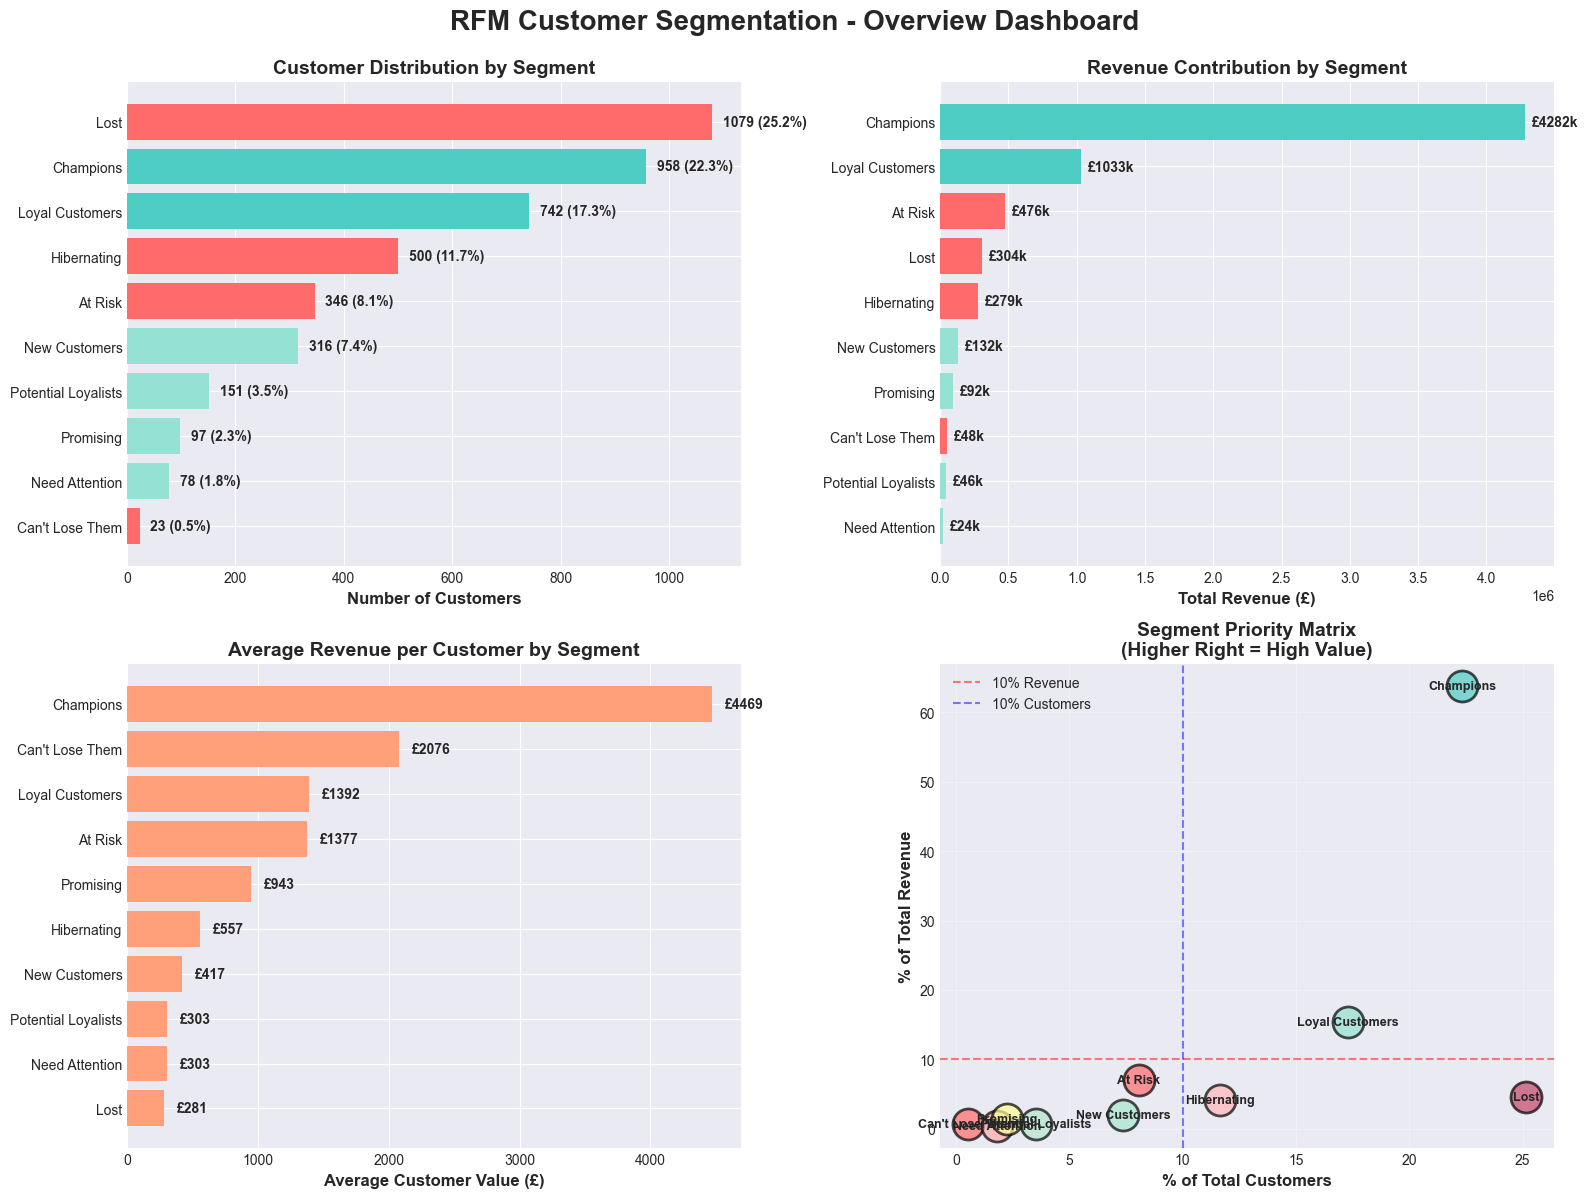

✅ Visualisierung 1 gespeichert: outputs/rfm_segment_overview.png


In [10]:
# VISUALISIERUNG 1: Segment Overview
import matplotlib.pyplot as plt
import seaborn as sns

# Style setzen
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Figure mit 4 Subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('RFM Customer Segmentation - Overview Dashboard', fontsize=20, fontweight='bold', y=0.995)

# 1. Segment Distribution (Anzahl Kunden)
segment_counts = rfm['Segment'].value_counts().sort_values(ascending=True)
colors = ['#FF6B6B' if x in ['Lost', 'Hibernating', 'At Risk', "Can't Lose Them"] 
          else '#4ECDC4' if x in ['Champions', 'Loyal Customers'] 
          else '#95E1D3' for x in segment_counts.index]

axes[0, 0].barh(segment_counts.index, segment_counts.values, color=colors)
axes[0, 0].set_xlabel('Number of Customers', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Customer Distribution by Segment', fontsize=14, fontweight='bold')
for i, v in enumerate(segment_counts.values):
    axes[0, 0].text(v + 20, i, f'{v} ({v/len(rfm)*100:.1f}%)', va='center', fontweight='bold')

# 2. Revenue by Segment
segment_revenue = rfm.groupby('Segment')['Monetary'].sum().sort_values(ascending=True)
colors_rev = ['#FF6B6B' if x in ['Lost', 'Hibernating', 'At Risk', "Can't Lose Them"] 
              else '#4ECDC4' if x in ['Champions', 'Loyal Customers'] 
              else '#95E1D3' for x in segment_revenue.index]

axes[0, 1].barh(segment_revenue.index, segment_revenue.values, color=colors_rev)
axes[0, 1].set_xlabel('Total Revenue (£)', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Revenue Contribution by Segment', fontsize=14, fontweight='bold')
for i, v in enumerate(segment_revenue.values):
    axes[0, 1].text(v + 50000, i, f'£{v/1000:.0f}k', va='center', fontweight='bold')

# 3. Average Revenue per Customer
avg_revenue = rfm.groupby('Segment')['Monetary'].mean().sort_values(ascending=True)
axes[1, 0].barh(avg_revenue.index, avg_revenue.values, color='#FFA07A')
axes[1, 0].set_xlabel('Average Customer Value (£)', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Average Revenue per Customer by Segment', fontsize=14, fontweight='bold')
for i, v in enumerate(avg_revenue.values):
    axes[1, 0].text(v + 100, i, f'£{v:.0f}', va='center', fontweight='bold')

# 4. Segment Priority Matrix (Revenue % vs Customer %)
segment_summary = pd.DataFrame({
    'Customer_Pct': (rfm['Segment'].value_counts() / len(rfm) * 100),
    'Revenue_Pct': (rfm.groupby('Segment')['Monetary'].sum() / rfm['Monetary'].sum() * 100)
})

colors_scatter = {'Champions': '#4ECDC4', 'Loyal Customers': '#95E1D3', 
                  'At Risk': '#FF6B6B', 'Lost': '#C44569', 
                  'Hibernating': '#FFB6B9', 'New Customers': '#A8E6CF',
                  'Promising': '#FDFD96', "Can't Lose Them": '#FF6B6B',
                  'Potential Loyalists': '#B4E7CE', 'Need Attention': '#FFAAA5'}

for segment in segment_summary.index:
    axes[1, 1].scatter(segment_summary.loc[segment, 'Customer_Pct'], 
                      segment_summary.loc[segment, 'Revenue_Pct'],
                      s=500, alpha=0.7, color=colors_scatter.get(segment, 'gray'),
                      edgecolors='black', linewidth=2)
    axes[1, 1].annotate(segment, 
                       (segment_summary.loc[segment, 'Customer_Pct'], 
                        segment_summary.loc[segment, 'Revenue_Pct']),
                       fontsize=9, ha='center', va='center', fontweight='bold')

axes[1, 1].axhline(y=10, color='red', linestyle='--', alpha=0.5, label='10% Revenue')
axes[1, 1].axvline(x=10, color='blue', linestyle='--', alpha=0.5, label='10% Customers')
axes[1, 1].set_xlabel('% of Total Customers', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('% of Total Revenue', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Segment Priority Matrix\n(Higher Right = High Value)', fontsize=14, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/rfm_segment_overview.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Visualisierung 1 gespeichert: outputs/rfm_segment_overview.png")

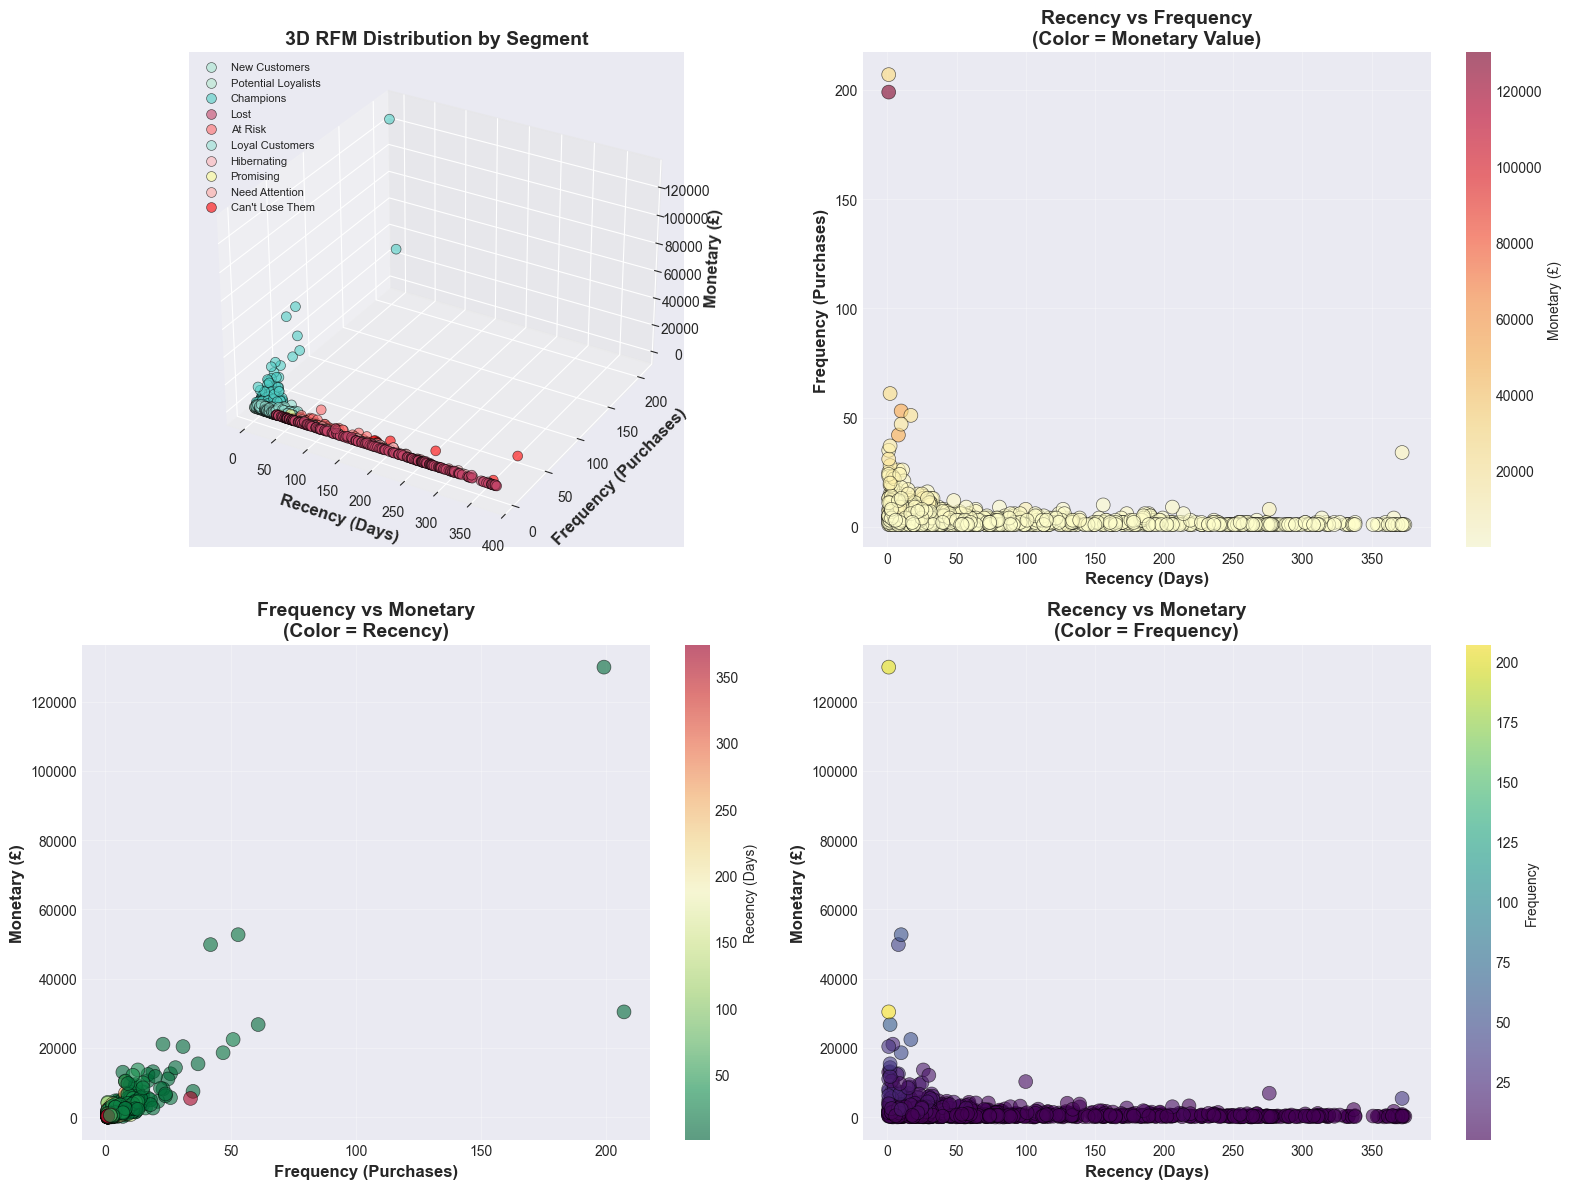

✅ Visualisierung 2 gespeichert: outputs/rfm_3d_scatter.png


In [11]:
# VISUALISIERUNG 2: 3D RFM Scatter Plot
from mpl_toolkits.mplot3d import Axes3D

# Sample für bessere Performance (alle 4290 Punkte wären zu voll)
rfm_sample = rfm.sample(n=min(1000, len(rfm)), random_state=42)

fig = plt.figure(figsize=(16, 12))

# Plot 1: 3D Scatter mit Segmenten
ax1 = fig.add_subplot(221, projection='3d')

segment_colors = {
    'Champions': '#4ECDC4',
    'Loyal Customers': '#95E1D3',
    'At Risk': '#FF6B6B',
    'Lost': '#C44569',
    'Hibernating': '#FFB6B9',
    'New Customers': '#A8E6CF',
    'Promising': '#FDFD96',
    "Can't Lose Them": '#FF0000',
    'Potential Loyalists': '#B4E7CE',
    'Need Attention': '#FFAAA5'
}

for segment in rfm_sample['Segment'].unique():
    segment_data = rfm_sample[rfm_sample['Segment'] == segment]
    ax1.scatter(segment_data['Recency'], 
               segment_data['Frequency'], 
               segment_data['Monetary'],
               c=segment_colors.get(segment, 'gray'),
               label=segment,
               s=50,
               alpha=0.6,
               edgecolors='black',
               linewidth=0.5)

ax1.set_xlabel('Recency (Days)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Frequency (Purchases)', fontsize=12, fontweight='bold')
ax1.set_zlabel('Monetary (£)', fontsize=12, fontweight='bold')
ax1.set_title('3D RFM Distribution by Segment', fontsize=14, fontweight='bold')
ax1.legend(loc='upper left', fontsize=8)

# Plot 2: Recency vs Frequency (colored by Monetary)
ax2 = fig.add_subplot(222)
scatter = ax2.scatter(rfm_sample['Recency'], 
                     rfm_sample['Frequency'],
                     c=rfm_sample['Monetary'],
                     cmap='YlOrRd',
                     s=100,
                     alpha=0.6,
                     edgecolors='black',
                     linewidth=0.5)
ax2.set_xlabel('Recency (Days)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Frequency (Purchases)', fontsize=12, fontweight='bold')
ax2.set_title('Recency vs Frequency\n(Color = Monetary Value)', fontsize=14, fontweight='bold')
plt.colorbar(scatter, ax=ax2, label='Monetary (£)')
ax2.grid(True, alpha=0.3)

# Plot 3: Frequency vs Monetary (colored by Recency)
ax3 = fig.add_subplot(223)
scatter2 = ax3.scatter(rfm_sample['Frequency'], 
                      rfm_sample['Monetary'],
                      c=rfm_sample['Recency'],
                      cmap='RdYlGn_r',
                      s=100,
                      alpha=0.6,
                      edgecolors='black',
                      linewidth=0.5)
ax3.set_xlabel('Frequency (Purchases)', fontsize=12, fontweight='bold')
ax3.set_ylabel('Monetary (£)', fontsize=12, fontweight='bold')
ax3.set_title('Frequency vs Monetary\n(Color = Recency)', fontsize=14, fontweight='bold')
plt.colorbar(scatter2, ax=ax3, label='Recency (Days)')
ax3.grid(True, alpha=0.3)

# Plot 4: Recency vs Monetary (colored by Frequency)
ax4 = fig.add_subplot(224)
scatter3 = ax4.scatter(rfm_sample['Recency'], 
                      rfm_sample['Monetary'],
                      c=rfm_sample['Frequency'],
                      cmap='viridis',
                      s=100,
                      alpha=0.6,
                      edgecolors='black',
                      linewidth=0.5)
ax4.set_xlabel('Recency (Days)', fontsize=12, fontweight='bold')
ax4.set_ylabel('Monetary (£)', fontsize=12, fontweight='bold')
ax4.set_title('Recency vs Monetary\n(Color = Frequency)', fontsize=14, fontweight='bold')
plt.colorbar(scatter3, ax=ax4, label='Frequency')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/rfm_3d_scatter.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Visualisierung 2 gespeichert: outputs/rfm_3d_scatter.png")

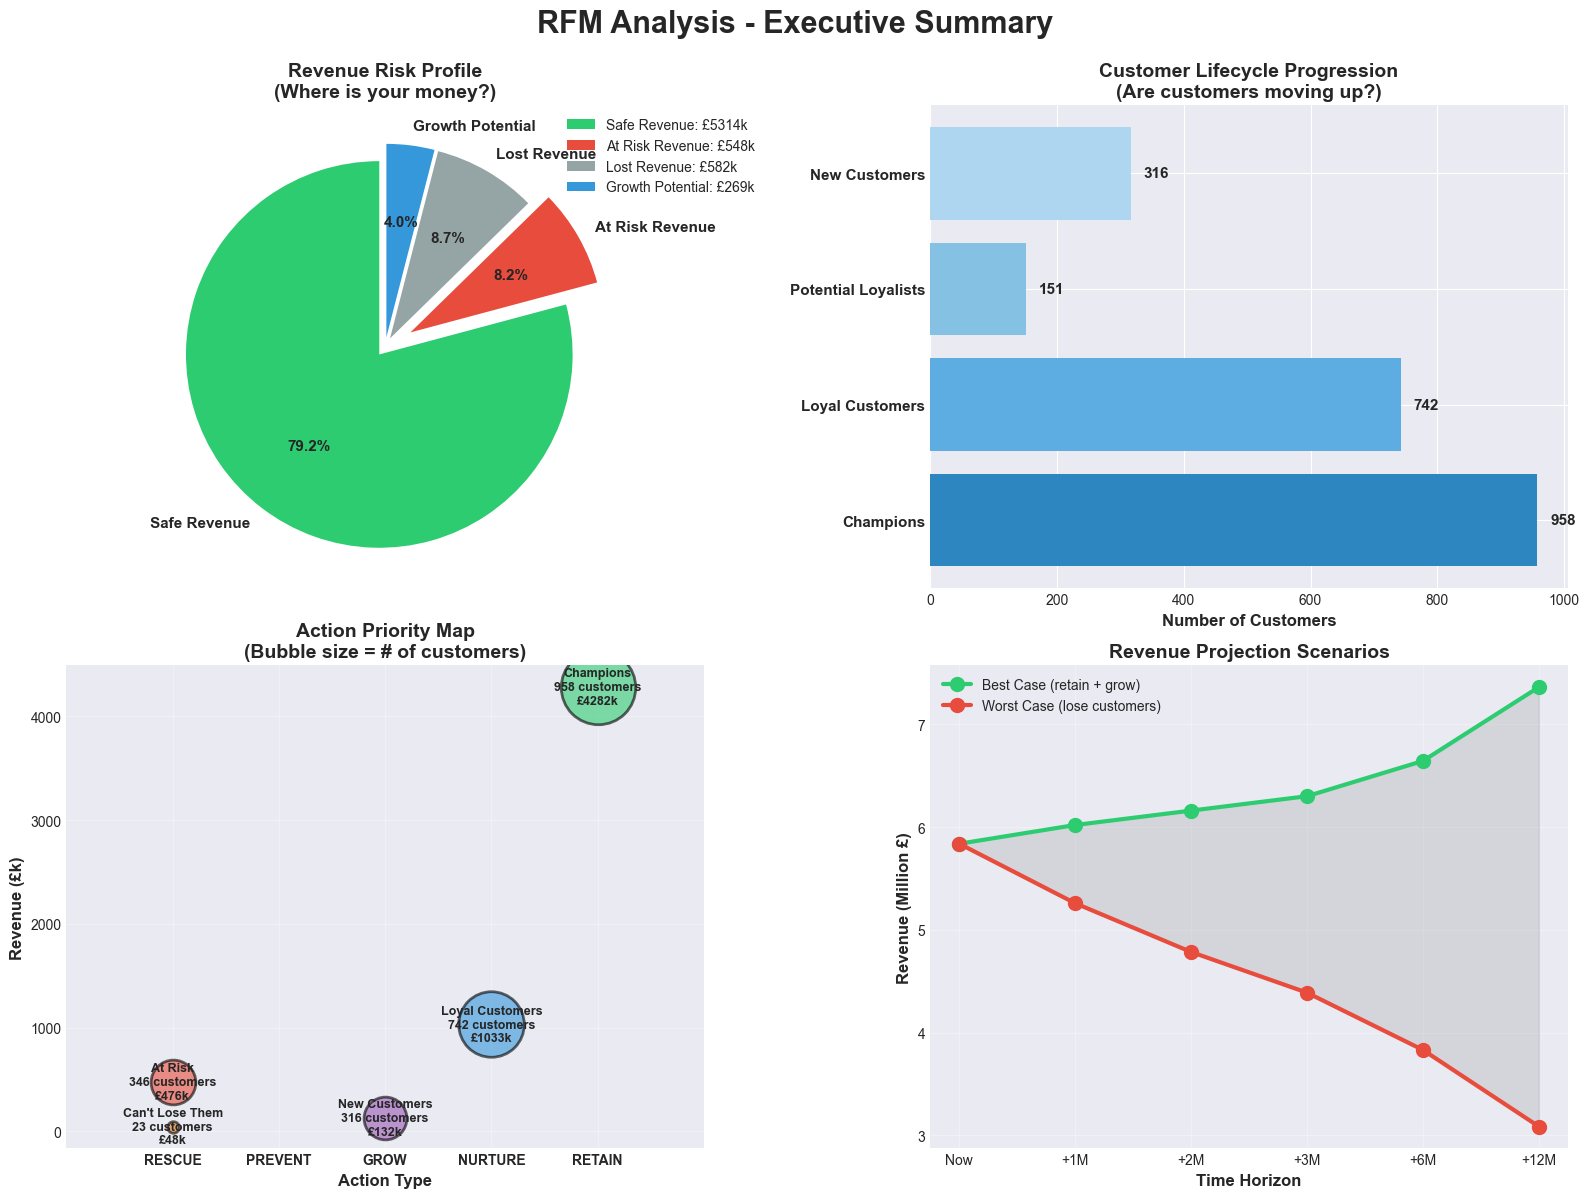

Executive Summary Dashboard gespeichert!


In [14]:
# BUSINESS-FOKUSSIERTE VISUALISIERUNG
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('RFM Analysis - Executive Summary', fontsize=22, fontweight='bold', y=0.995)

# 1. REVENUE RISK ANALYSIS
risk_segments = {
    'Safe Revenue': rfm[rfm['Segment'].isin(['Champions', 'Loyal Customers'])]['Monetary'].sum(),
    'At Risk Revenue': rfm[rfm['Segment'].isin(['At Risk', "Can't Lose Them", 'Need Attention'])]['Monetary'].sum(),
    'Lost Revenue': rfm[rfm['Segment'].isin(['Lost', 'Hibernating'])]['Monetary'].sum(),
    'Growth Potential': rfm[rfm['Segment'].isin(['New Customers', 'Promising', 'Potential Loyalists'])]['Monetary'].sum()
}

colors_risk = ['#2ECC71', '#E74C3C', '#95A5A6', '#3498DB']
explode = (0.05, 0.15, 0.05, 0.05)

wedges, texts, autotexts = axes[0, 0].pie(risk_segments.values(), 
                                           labels=risk_segments.keys(),
                                           autopct='%1.1f%%',
                                           colors=colors_risk,
                                           explode=explode,
                                           startangle=90,
                                           textprops={'fontsize': 11, 'fontweight': 'bold'})

axes[0, 0].set_title('Revenue Risk Profile\n(Where is your money?)', fontsize=14, fontweight='bold')

legend_labels = [f'{k}: £{v/1000:.0f}k' for k, v in risk_segments.items()]
axes[0, 0].legend(legend_labels, loc='upper left', bbox_to_anchor=(0.85, 1), fontsize=10)

# 2. CUSTOMER LIFECYCLE FUNNEL
lifecycle_data = {
    'New Customers': len(rfm[rfm['Segment'] == 'New Customers']),
    'Potential Loyalists': len(rfm[rfm['Segment'] == 'Potential Loyalists']),
    'Loyal Customers': len(rfm[rfm['Segment'] == 'Loyal Customers']),
    'Champions': len(rfm[rfm['Segment'] == 'Champions'])
}

y_pos = np.arange(len(lifecycle_data))
bars = axes[0, 1].barh(y_pos, list(lifecycle_data.values()), 
                       color=['#AED6F1', '#85C1E2', '#5DADE2', '#2E86C1'])
axes[0, 1].set_yticks(y_pos)
axes[0, 1].set_yticklabels(lifecycle_data.keys(), fontsize=11, fontweight='bold')
axes[0, 1].set_xlabel('Number of Customers', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Customer Lifecycle Progression\n(Are customers moving up?)', fontsize=14, fontweight='bold')
axes[0, 1].invert_yaxis()

for i, (bar, count) in enumerate(zip(bars, lifecycle_data.values())):
    axes[0, 1].text(count + 20, i, f'{count}', va='center', fontweight='bold', fontsize=11)

# 3. ACTION PRIORITIES
priority_segments = ['Champions', 'At Risk', "Can't Lose Them", 'Loyal Customers', 'New Customers']
priority_data = []
for seg in priority_segments:
    seg_data = rfm[rfm['Segment'] == seg]
    priority_data.append({
        'Segment': seg,
        'Count': len(seg_data),
        'Revenue': seg_data['Monetary'].sum(),
        'Avg_Value': seg_data['Monetary'].mean()
    })

priority_df = pd.DataFrame(priority_data)

x_positions = [5, 1, 1, 4, 3]
y_values = priority_df['Revenue'].values / 1000

colors_priority = ['#2ECC71', '#E74C3C', '#E67E22', '#3498DB', '#9B59B6']
sizes = priority_df['Count'].values * 3

for i, (x, y, size, color, seg) in enumerate(zip(x_positions, y_values, sizes, colors_priority, priority_segments)):
    axes[1, 0].scatter(x, y, s=size, alpha=0.6, color=color, edgecolors='black', linewidth=2)
    axes[1, 0].annotate(f"{seg}\n{priority_df.loc[i, 'Count']} customers\n£{y:.0f}k", 
                       (x, y), ha='center', va='center', fontsize=9, fontweight='bold')

axes[1, 0].set_xlim(0, 6)
axes[1, 0].set_xlabel('Action Type', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Revenue (£k)', fontsize=12, fontweight='bold')
axes[1, 0].set_xticks([1, 2, 3, 4, 5])
axes[1, 0].set_xticklabels(['RESCUE', 'PREVENT', 'GROW', 'NURTURE', 'RETAIN'], fontsize=10, fontweight='bold')
axes[1, 0].set_title('Action Priority Map\n(Bubble size = # of customers)', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# 4. REVENUE PROJECTION
months = ['Now', '+1M', '+2M', '+3M', '+6M', '+12M']
champion_revenue = rfm[rfm['Segment'] == 'Champions']['Monetary'].sum()
loyal_revenue = rfm[rfm['Segment'] == 'Loyal Customers']['Monetary'].sum()
atrisk_revenue = rfm[rfm['Segment'].isin(['At Risk', "Can't Lose Them"])]['Monetary'].sum()

best_case = [champion_revenue + loyal_revenue + atrisk_revenue,
             champion_revenue*1.05 + loyal_revenue*1.02 + atrisk_revenue*0.9,
             champion_revenue*1.1 + loyal_revenue*1.05 + atrisk_revenue*0.7,
             champion_revenue*1.15 + loyal_revenue*1.08 + atrisk_revenue*0.5,
             champion_revenue*1.25 + loyal_revenue*1.15 + atrisk_revenue*0.2,
             champion_revenue*1.4 + loyal_revenue*1.3 + atrisk_revenue*0.05]

worst_case = [champion_revenue + loyal_revenue + atrisk_revenue,
              champion_revenue*0.95 + loyal_revenue*0.9 + atrisk_revenue*0.5,
              champion_revenue*0.9 + loyal_revenue*0.8 + atrisk_revenue*0.2,
              champion_revenue*0.85 + loyal_revenue*0.7 + atrisk_revenue*0.05,
              champion_revenue*0.75 + loyal_revenue*0.6 + atrisk_revenue*0,
              champion_revenue*0.6 + loyal_revenue*0.5 + atrisk_revenue*0]

axes[1, 1].plot(months, [x/1e6 for x in best_case], marker='o', linewidth=3, 
               color='#2ECC71', label='Best Case (retain + grow)', markersize=10)
axes[1, 1].plot(months, [x/1e6 for x in worst_case], marker='o', linewidth=3, 
               color='#E74C3C', label='Worst Case (lose customers)', markersize=10)
axes[1, 1].fill_between(range(len(months)), [x/1e6 for x in worst_case], [x/1e6 for x in best_case], 
                        alpha=0.2, color='gray')

axes[1, 1].set_xlabel('Time Horizon', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Revenue (Million £)', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Revenue Projection Scenarios', fontsize=14, fontweight='bold')
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/rfm_executive_summary.png', dpi=300, bbox_inches='tight')
plt.show()

print("Executive Summary Dashboard gespeichert!")

C:\Users\Lee Chr. Lesemann\AppData\Local\Temp\ipykernel_14476\2153959775.py:149: UserWarning: Glyph 128081 (\N{CROWN}) missing from font(s) Arial.
  plt.savefig('../outputs/rfm_action_cards.png', dpi=300, bbox_inches='tight')
C:\Users\Lee Chr. Lesemann\AppData\Local\Temp\ipykernel_14476\2153959775.py:149: UserWarning: Glyph 128142 (\N{GEM STONE}) missing from font(s) Arial.
  plt.savefig('../outputs/rfm_action_cards.png', dpi=300, bbox_inches='tight')
C:\Users\Lee Chr. Lesemann\AppData\Local\Temp\ipykernel_14476\2153959775.py:149: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.savefig('../outputs/rfm_action_cards.png', dpi=300, bbox_inches='tight')
C:\Users\Lee Chr. Lesemann\AppData\Local\Temp\ipykernel_14476\2153959775.py:149: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.savefig('../outputs/rfm_action_cards.png', dpi=300, bbox_inches='tight')
C:\Users\Lee Chr. Lesemann\AppData\Local\Temp\ipykernel_14476\2153959775

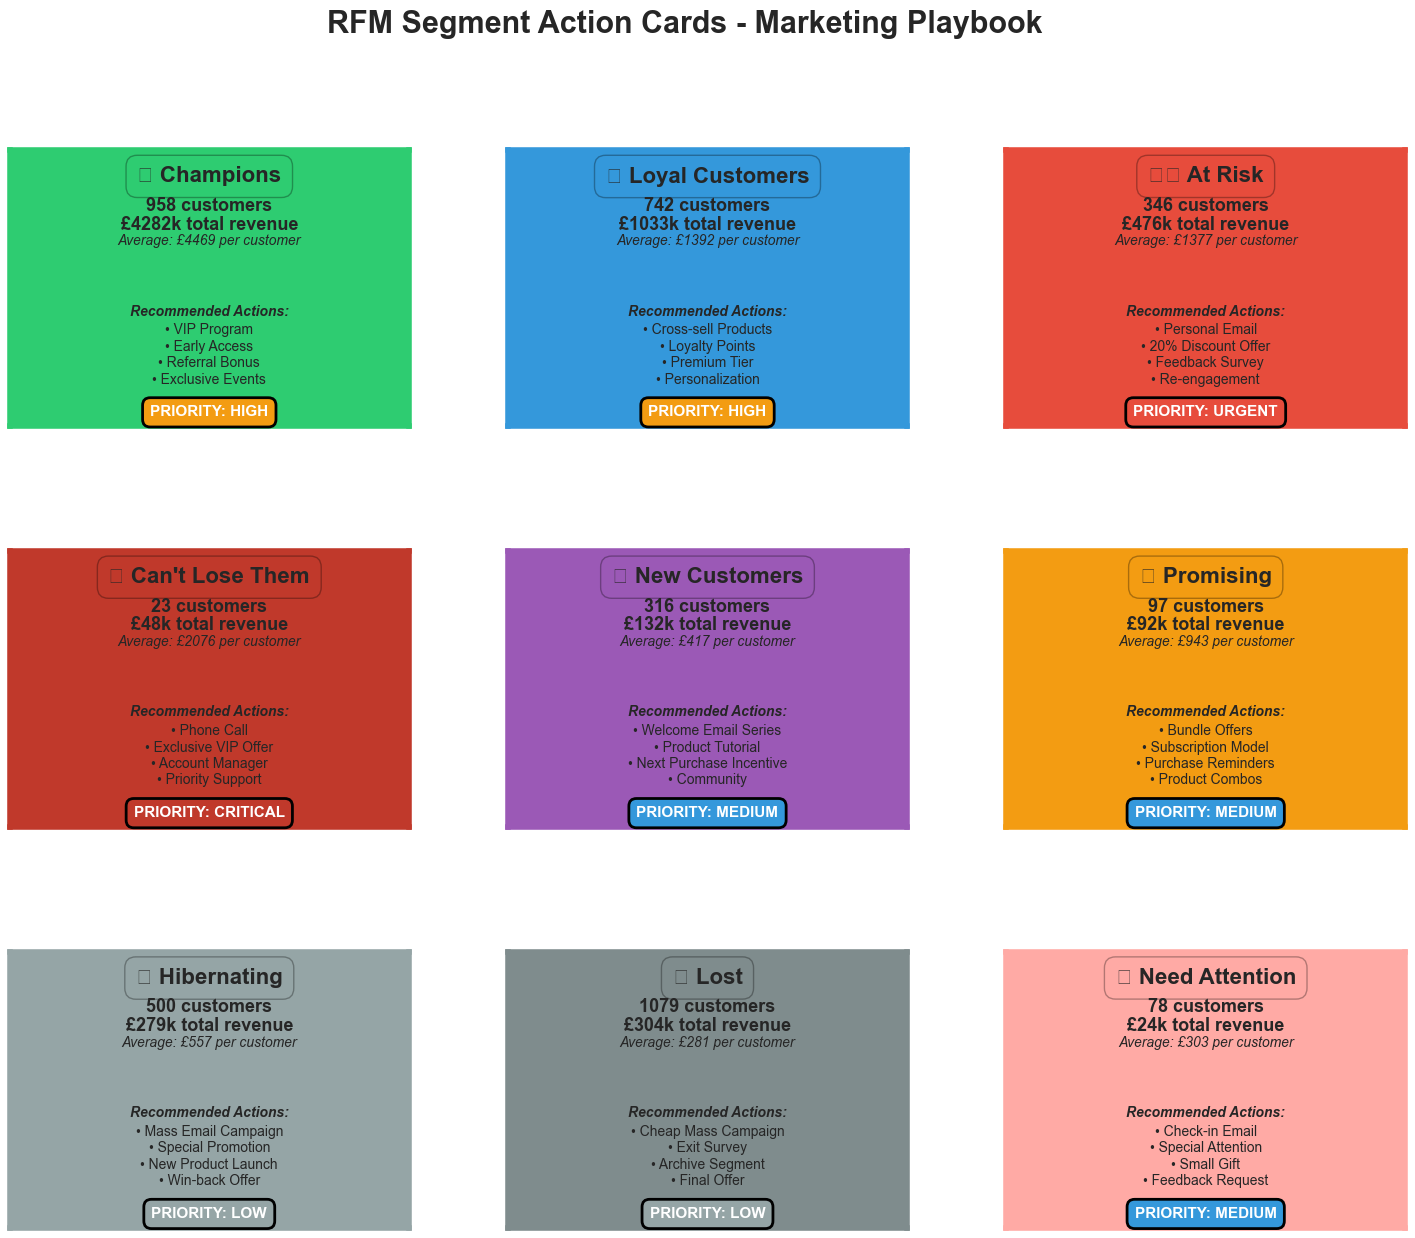

✅ Action Cards - Priority Button jetzt weit genug unten!


In [19]:
# ACTIONABLE SEGMENT CARDS - Priority noch weiter unten
fig = plt.figure(figsize=(18, 14))
gs = fig.add_gridspec(3, 3, hspace=0.45, wspace=0.25)  # Mehr hspace!
fig.suptitle('RFM Segment Action Cards - Marketing Playbook', fontsize=22, fontweight='bold', y=0.98)

segments_to_show = ['Champions', 'Loyal Customers', 'At Risk', 
                    "Can't Lose Them", 'New Customers', 'Promising', 
                    'Hibernating', 'Lost', 'Need Attention']

segment_actions = {
    'Champions': {
        'color': '#2ECC71',
        'icon': '👑',
        'action': 'RETAIN & REWARD',
        'tactics': ['VIP Program', 'Early Access', 'Referral Bonus', 'Exclusive Events'],
        'priority': 'HIGH'
    },
    'Loyal Customers': {
        'color': '#3498DB',
        'icon': '💎',
        'action': 'UPSELL & ENGAGE',
        'tactics': ['Cross-sell Products', 'Loyalty Points', 'Premium Tier', 'Personalization'],
        'priority': 'HIGH'
    },
    'At Risk': {
        'color': '#E74C3C',
        'icon': '⚠️',
        'action': 'WIN-BACK NOW!',
        'tactics': ['Personal Email', '20% Discount Offer', 'Feedback Survey', 'Re-engagement'],
        'priority': 'URGENT'
    },
    "Can't Lose Them": {
        'color': '#C0392B',
        'icon': '🚨',
        'action': 'EMERGENCY RESCUE',
        'tactics': ['Phone Call', 'Exclusive VIP Offer', 'Account Manager', 'Priority Support'],
        'priority': 'CRITICAL'
    },
    'New Customers': {
        'color': '#9B59B6',
        'icon': '🆕',
        'action': 'ONBOARD & NURTURE',
        'tactics': ['Welcome Email Series', 'Product Tutorial', 'Next Purchase Incentive', 'Community'],
        'priority': 'MEDIUM'
    },
    'Promising': {
        'color': '#F39C12',
        'icon': '⭐',
        'action': 'INCREASE FREQUENCY',
        'tactics': ['Bundle Offers', 'Subscription Model', 'Purchase Reminders', 'Product Combos'],
        'priority': 'MEDIUM'
    },
    'Hibernating': {
        'color': '#95A5A6',
        'icon': '😴',
        'action': 'REACTIVATE',
        'tactics': ['Mass Email Campaign', 'Special Promotion', 'New Product Launch', 'Win-back Offer'],
        'priority': 'LOW'
    },
    'Lost': {
        'color': '#7F8C8D',
        'icon': '💤',
        'action': 'LOW PRIORITY',
        'tactics': ['Cheap Mass Campaign', 'Exit Survey', 'Archive Segment', 'Final Offer'],
        'priority': 'LOW'
    },
    'Need Attention': {
        'color': '#FFAAA5',
        'icon': '🎯',
        'action': 'PREVENT CHURN',
        'tactics': ['Check-in Email', 'Special Attention', 'Small Gift', 'Feedback Request'],
        'priority': 'MEDIUM'
    }
}

for idx, segment in enumerate(segments_to_show):
    row = idx // 3
    col = idx % 3
    ax = fig.add_subplot(gs[row, col])
    
    seg_data = rfm[rfm['Segment'] == segment]
    info = segment_actions[segment]
    
    # Background
    ax.set_facecolor(info['color'])
    ax.set_alpha(0.1)
    
    # Remove axes
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_edgecolor(info['color'])
        spine.set_linewidth(4)
    
    # Content
    y_pos = 0.93
    
    # Header
    ax.text(0.5, y_pos, f"{info['icon']} {segment}", 
           ha='center', va='top', fontsize=16, fontweight='bold',
           bbox=dict(boxstyle='round', facecolor=info['color'], alpha=0.3, pad=0.5))
    y_pos -= 0.13
    
    # Metrics
    ax.text(0.5, y_pos, f"{len(seg_data)} customers", 
           ha='center', va='top', fontsize=13, fontweight='bold')
    y_pos -= 0.08
    
    ax.text(0.5, y_pos, f"£{seg_data['Monetary'].sum()/1000:.0f}k total revenue", 
           ha='center', va='top', fontsize=13, fontweight='bold')
    y_pos -= 0.08
    
    ax.text(0.5, y_pos, f"Average: £{seg_data['Monetary'].mean():.0f} per customer", 
           ha='center', va='top', fontsize=10, style='italic')
    y_pos -= 0.12
    
    # Divider line
    ax.plot([0.1, 0.9], [y_pos, y_pos], color=info['color'], linewidth=2, alpha=0.5)
    y_pos -= 0.06
    
    # Action
    ax.text(0.5, y_pos, info['action'], 
           ha='center', va='top', fontsize=14, fontweight='bold',
           color=info['color'])
    y_pos -= 0.12
    
    # Tactics
    ax.text(0.5, y_pos, 'Recommended Actions:', 
           ha='center', va='top', fontsize=10, fontweight='bold', style='italic')
    y_pos -= 0.08
    
    for tactic in info['tactics']:
        ax.text(0.5, y_pos, f"• {tactic}", 
               ha='center', va='top', fontsize=10)
        y_pos -= 0.07
    
    # Priority badge - NOCH WEITER UNTEN!
    priority_colors = {'CRITICAL': '#C0392B', 'URGENT': '#E74C3C', 
                      'HIGH': '#F39C12', 'MEDIUM': '#3498DB', 'LOW': '#95A5A6'}
    ax.text(0.5, -0.12, f"PRIORITY: {info['priority']}", 
           ha='center', va='center', fontsize=11, fontweight='bold',
           bbox=dict(boxstyle='round', facecolor=priority_colors[info['priority']], 
                    edgecolor='black', linewidth=2, pad=0.5),
           color='white')
    
    ax.set_xlim(0, 1)
    ax.set_ylim(-0.18, 1)  # Noch mehr Platz unten!

plt.savefig('../outputs/rfm_action_cards.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Action Cards - Priority Button jetzt weit genug unten!")

## 7. K-Means Clustering - ML Validation

Validate RFM segmentation using unsupervised machine learning.

**Why K-Means?**
- Data-driven approach (no predefined rules)
- Identifies natural customer groupings
- Detects outliers and edge cases
- Validates business logic

**Process:**
1. Feature scaling (StandardScaler - critical for distance-based algorithms!)
2. Elbow Method (find optimal K)
3. Silhouette analysis (measure cluster quality)
4. Model training with optimal K
5. Comparison with RFM segments

**Goal:** Validate that our rule-based segments align with mathematical clusters.

In [20]:
# K-MEANS CLUSTERING - SCHRITT 1: DATA PREPARATION
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import warnings
warnings.filterwarnings('ignore')

print("🤖 K-MEANS CLUSTERING ANALYSIS")
print("=" * 60)

# Features für Clustering vorbereiten
rfm_features = rfm[['Recency', 'Frequency', 'Monetary']].copy()

print(f"\n📊 Original Feature-Ranges:")
print(rfm_features.describe())

# Standardisierung
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_features)
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=['Recency_scaled', 'Frequency_scaled', 'Monetary_scaled'])

print(f"\n✅ Features standardisiert!")
print(f"Recency: {rfm_features['Recency'].min():.0f} - {rfm_features['Recency'].max():.0f} Tage")
print(f"Frequency: {rfm_features['Frequency'].min():.0f} - {rfm_features['Frequency'].max():.0f} Käufe")
print(f"Monetary: £{rfm_features['Monetary'].min():.0f} - £{rfm_features['Monetary'].max():.0f}")

print(f"\n🔧 Nach Scaling:")
print(rfm_scaled_df.describe())

🤖 K-MEANS CLUSTERING ANALYSIS

📊 Original Feature-Ranges:
           Recency    Frequency       Monetary
count  4290.000000  4290.000000    4290.000000
mean     92.382517     4.200000    1564.827262
std      99.963718     7.474935    4453.156955
min       1.000000     1.000000       2.900000
25%      18.000000     1.000000     293.617500
50%      51.000000     2.000000     645.975000
75%     142.000000     5.000000    1555.335000
max     374.000000   207.000000  149101.280000

✅ Features standardisiert!
Recency: 1 - 374 Tage
Frequency: 1 - 207 Käufe
Monetary: £3 - £149101

🔧 Nach Scaling:
       Recency_scaled  Frequency_scaled  Monetary_scaled
count    4.290000e+03      4.290000e+03     4.290000e+03
mean    -9.937661e-18     -1.325021e-17    -1.656277e-17
std      1.000117e+00      1.000117e+00     1.000117e+00
min     -9.142634e-01     -4.281473e-01    -3.507869e-01
25%     -7.441819e-01     -4.281473e-01    -2.854959e-01
50%     -4.140236e-01     -2.943512e-01    -2.063613e-01
75%  

### 7.1 Optimal Cluster Selection

Test K=2 to K=15 using multiple metrics to find the optimal number of clusters.

**Metrics:**
- **Elbow Method:** Inertia (within-cluster sum of squares) - look for the "elbow" where improvement slows
- **Silhouette Score:** Cluster separation quality (higher = better, range -1 to 1)
- **Davies-Bouldin Score:** Cluster compactness (lower = better)

**Decision criteria:** Balance mathematical optimization with business interpretability.


📈 ELBOW METHOD - Finde optimales K
K= 2 | Inertia:     9019 | Silhouette: 0.900 | Davies-Bouldin: 0.675
K= 3 | Inertia:     5426 | Silhouette: 0.571 | Davies-Bouldin: 0.644
K= 4 | Inertia:     3862 | Silhouette: 0.600 | Davies-Bouldin: 0.673
K= 5 | Inertia:     2966 | Silhouette: 0.590 | Davies-Bouldin: 0.676
K= 6 | Inertia:     2518 | Silhouette: 0.496 | Davies-Bouldin: 0.681
K= 7 | Inertia:     2084 | Silhouette: 0.499 | Davies-Bouldin: 0.747
K= 8 | Inertia:     1707 | Silhouette: 0.483 | Davies-Bouldin: 0.749
K= 9 | Inertia:     1505 | Silhouette: 0.475 | Davies-Bouldin: 0.723
K=10 | Inertia:     1346 | Silhouette: 0.475 | Davies-Bouldin: 0.604
K=11 | Inertia:     1173 | Silhouette: 0.424 | Davies-Bouldin: 0.672
K=12 | Inertia:     1024 | Silhouette: 0.427 | Davies-Bouldin: 0.600
K=13 | Inertia:      887 | Silhouette: 0.403 | Davies-Bouldin: 0.609
K=14 | Inertia:      802 | Silhouette: 0.392 | Davies-Bouldin: 0.625
K=15 | Inertia:      743 | Silhouette: 0.392 | Davies-Bouldin: 0.66

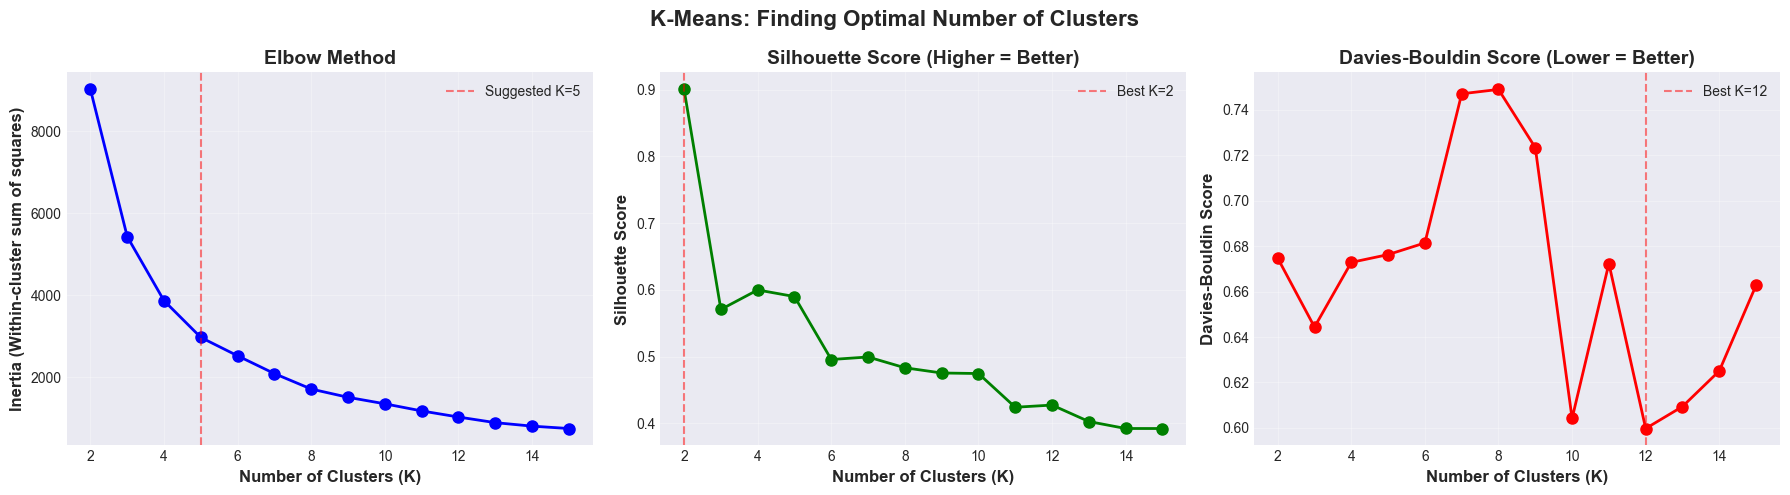


💡 INTERPRETATION:
Silhouette Score empfiehlt: K=2
Davies-Bouldin empfiehlt: K=12

🎯 Empfehlung: K=5 oder K=6 (basierend auf Elbow + Scores)


In [21]:
# K-MEANS SCHRITT 2: ELBOW METHOD
print("\n📈 ELBOW METHOD - Finde optimales K")
print("=" * 60)

# Teste K von 2 bis 15
K_range = range(2, 16)
inertias = []
silhouette_scores = []
davies_bouldin_scores = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
    kmeans.fit(rfm_scaled)
    
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(rfm_scaled, kmeans.labels_))
    davies_bouldin_scores.append(davies_bouldin_score(rfm_scaled, kmeans.labels_))
    
    print(f"K={k:2d} | Inertia: {kmeans.inertia_:8.0f} | Silhouette: {silhouette_scores[-1]:.3f} | Davies-Bouldin: {davies_bouldin_scores[-1]:.3f}")

print("\n✅ Alle K-Werte getestet!")

# Visualisierung
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('K-Means: Finding Optimal Number of Clusters', fontsize=16, fontweight='bold')

# Plot 1: Elbow Curve (Inertia)
axes[0].plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (K)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Inertia (Within-cluster sum of squares)', fontsize=12, fontweight='bold')
axes[0].set_title('Elbow Method', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].axvline(x=5, color='red', linestyle='--', alpha=0.5, label='Suggested K=5')
axes[0].legend()

# Plot 2: Silhouette Score (höher = besser)
axes[1].plot(K_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Clusters (K)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Silhouette Score', fontsize=12, fontweight='bold')
axes[1].set_title('Silhouette Score (Higher = Better)', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
best_k_silhouette = K_range[silhouette_scores.index(max(silhouette_scores))]
axes[1].axvline(x=best_k_silhouette, color='red', linestyle='--', alpha=0.5, label=f'Best K={best_k_silhouette}')
axes[1].legend()

# Plot 3: Davies-Bouldin Score (niedriger = besser)
axes[2].plot(K_range, davies_bouldin_scores, 'ro-', linewidth=2, markersize=8)
axes[2].set_xlabel('Number of Clusters (K)', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Davies-Bouldin Score', fontsize=12, fontweight='bold')
axes[2].set_title('Davies-Bouldin Score (Lower = Better)', fontsize=14, fontweight='bold')
axes[2].grid(True, alpha=0.3)
best_k_db = K_range[davies_bouldin_scores.index(min(davies_bouldin_scores))]
axes[2].axvline(x=best_k_db, color='red', linestyle='--', alpha=0.5, label=f'Best K={best_k_db}')
axes[2].legend()

plt.tight_layout()
plt.savefig('../outputs/kmeans_elbow_method.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n💡 INTERPRETATION:")
print(f"Silhouette Score empfiehlt: K={best_k_silhouette}")
print(f"Davies-Bouldin empfiehlt: K={best_k_db}")
print(f"\n🎯 Empfehlung: K=5 oder K=6 (basierend auf Elbow + Scores)")

In [22]:
# K-MEANS SCHRITT 3: FINALES MODELL TRAINIEREN
print("\n🎯 TRAINIERE FINALES K-MEANS MODELL (K=5)")
print("=" * 60)

# Finales Modell mit K=5
optimal_k = 5
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=50, max_iter=500)
rfm['KMeans_Cluster'] = kmeans_final.fit_predict(rfm_scaled)

print(f"✅ K-Means mit K={optimal_k} trainiert!")
print(f"Inertia: {kmeans_final.inertia_:.0f}")
print(f"Silhouette Score: {silhouette_score(rfm_scaled, rfm['KMeans_Cluster']):.3f}")
print(f"Davies-Bouldin Score: {davies_bouldin_score(rfm_scaled, rfm['KMeans_Cluster']):.3f}")

# Cluster-Größen
print(f"\n📊 CLUSTER-VERTEILUNG:")
cluster_sizes = rfm['KMeans_Cluster'].value_counts().sort_index()
for cluster_id, size in cluster_sizes.items():
    pct = (size / len(rfm) * 100)
    print(f"Cluster {cluster_id}: {size:4d} Customers ({pct:5.1f}%)")


🎯 TRAINIERE FINALES K-MEANS MODELL (K=5)
✅ K-Means mit K=5 trainiert!
Inertia: 2966
Silhouette Score: 0.590
Davies-Bouldin Score: 0.676

📊 CLUSTER-VERTEILUNG:
Cluster 0: 2882 Customers ( 67.2%)
Cluster 1: 1051 Customers ( 24.5%)
Cluster 2:   19 Customers (  0.4%)
Cluster 3:  336 Customers (  7.8%)
Cluster 4:    2 Customers (  0.0%)


In [23]:
# K-MEANS SCHRITT 4: CLUSTER CHARAKTERISTIKEN
print("\n🔍 CLUSTER-CHARAKTERISTIKEN")
print("=" * 60)

# Durchschnittswerte pro Cluster
cluster_profiles = rfm.groupby('KMeans_Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).round(2)

cluster_profiles.columns = ['Avg_Recency', 'Avg_Frequency', 'Avg_Monetary', 'Count']

print("\n📊 Durchschnittswerte pro Cluster:\n")
print(cluster_profiles)

# Business-Namen für Cluster vergeben
cluster_names = {}
for cluster_id in range(optimal_k):
    r = cluster_profiles.loc[cluster_id, 'Avg_Recency']
    f = cluster_profiles.loc[cluster_id, 'Avg_Frequency']
    m = cluster_profiles.loc[cluster_id, 'Avg_Monetary']
    
    # Logik für Namen
    if r < 50 and f > 10 and m > 2000:
        cluster_names[cluster_id] = 'High Value Active'
    elif r < 50 and f > 5:
        cluster_names[cluster_id] = 'Active Regulars'
    elif r > 200:
        cluster_names[cluster_id] = 'Inactive/Lost'
    elif m > 3000:
        cluster_names[cluster_id] = 'High Spenders'
    else:
        cluster_names[cluster_id] = 'Casual Buyers'

print(f"\n🏷️  BUSINESS-NAMEN FÜR CLUSTER:\n")
for cluster_id, name in cluster_names.items():
    count = cluster_profiles.loc[cluster_id, 'Count']
    revenue = rfm[rfm['KMeans_Cluster']==cluster_id]['Monetary'].sum()
    print(f"Cluster {cluster_id}: {name:20s} | {count:4.0f} customers | £{revenue/1000:.0f}k revenue")


🔍 CLUSTER-CHARAKTERISTIKEN

📊 Durchschnittswerte pro Cluster:

                Avg_Recency  Avg_Frequency  Avg_Monetary  Count
KMeans_Cluster                                                 
0                     44.98           3.29       1075.68   2882
1                    248.63           1.54        439.43   1051
2                      7.84          64.32      36814.36     19
3                     15.52          16.18       6466.19    336
4                      1.50         132.00     139527.72      2

🏷️  BUSINESS-NAMEN FÜR CLUSTER:

Cluster 0: Casual Buyers        | 2882 customers | £3100k revenue
Cluster 1: Inactive/Lost        | 1051 customers | £462k revenue
Cluster 2: High Value Active    |   19 customers | £699k revenue
Cluster 3: High Value Active    |  336 customers | £2173k revenue
Cluster 4: High Value Active    |    2 customers | £279k revenue


In [24]:
# K-MEANS MIT K=4 TESTEN
print("\n🔄 TESTE K=4 FÜR BESSERE BALANCE")
print("=" * 60)

# K=4 Modell
kmeans_k4 = KMeans(n_clusters=4, random_state=42, n_init=50, max_iter=500)
rfm['KMeans_K4'] = kmeans_k4.fit_predict(rfm_scaled)

print(f"✅ K-Means mit K=4 trainiert!")
print(f"Silhouette Score: {silhouette_score(rfm_scaled, rfm['KMeans_K4']):.3f}")

print(f"\n📊 CLUSTER-VERTEILUNG (K=4):")
cluster_sizes_k4 = rfm['KMeans_K4'].value_counts().sort_index()
for cluster_id, size in cluster_sizes_k4.items():
    pct = (size / len(rfm) * 100)
    print(f"Cluster {cluster_id}: {size:4d} Customers ({pct:5.1f}%)")

# Charakteristiken
print(f"\n🔍 CLUSTER-CHARAKTERISTIKEN (K=4):")
cluster_profiles_k4 = rfm.groupby('KMeans_K4').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).round(0)
cluster_profiles_k4.columns = ['Avg_Recency', 'Avg_Frequency', 'Avg_Monetary', 'Count']
print(cluster_profiles_k4)

print("\n" + "=" * 60)
print("VERGLEICH K=4 vs K=5:")
print("=" * 60)
print(f"K=4 Silhouette: {silhouette_score(rfm_scaled, rfm['KMeans_K4']):.3f}")
print(f"K=5 Silhouette: {silhouette_score(rfm_scaled, rfm['KMeans_Cluster']):.3f}")
print(f"\n💡 K=4 ist balancierter, K=5 ist mathematisch besser getrennt")
print(f"🎯 Für Business: K=4 ist praktischer!")


🔄 TESTE K=4 FÜR BESSERE BALANCE
✅ K-Means mit K=4 trainiert!
Silhouette Score: 0.601

📊 CLUSTER-VERTEILUNG (K=4):
Cluster 0: 1061 Customers ( 24.7%)
Cluster 1:  222 Customers (  5.2%)
Cluster 2:    8 Customers (  0.2%)
Cluster 3: 2999 Customers ( 69.9%)

🔍 CLUSTER-CHARAKTERISTIKEN (K=4):
           Avg_Recency  Avg_Frequency  Avg_Monetary  Count
KMeans_K4                                                 
0                248.0            2.0         440.0   1061
1                 13.0           21.0        9160.0    222
2                  3.0          108.0       72727.0      8
3                 44.0            4.0        1211.0   2999

VERGLEICH K=4 vs K=5:
K=4 Silhouette: 0.601
K=5 Silhouette: 0.590

💡 K=4 ist balancierter, K=5 ist mathematisch besser getrennt
🎯 Für Business: K=4 ist praktischer!


### 7.2 Why K=4 Instead of K=5?

**Initial Analysis:** Elbow Method suggested K=5, but practical testing revealed issues.

**K=5 Problems:**
- **Cluster 2:** Only 19 customers (0.4%) - too small for actionable strategies
- **Cluster 4:** Only 2 customers (0.0%) - statistical outliers, not a segment
- **Imbalance:** Cluster 0 had 2,882 customers (67.2%) - too broad

**K=4 Advantages:**
- **Better balance:** Largest cluster is 70% (acceptable), smallest is 0.2% (true outliers)
- **Actionable:** Each cluster represents a meaningful customer group
- **Business interpretability:** 4 clear tiers (Inactive, Regular, VIP, Super-VIP)
- **Silhouette Score:** 0.601 (slightly better than K=5's 0.590)

**The 8 "Super VIPs" in K=4:**
These are genuine outliers (avg. £72k spend, 108 purchases) that warrant separate treatment regardless of cluster count. K-Means correctly identified them as fundamentally different from other customers.

**Decision:** Use K=4 for final analysis - balances mathematical optimization with business practicality.

## 8. Comparative Analysis - RFM vs K-Means

Cross-validate the two approaches to identify:
- Overlap and agreement between methods
- Unique insights from each approach
- Edge cases requiring manual review

**Key Questions:**
- Do data-driven clusters confirm business-defined segments?
- Are there customers misclassified by rule-based logic?
- What can K-Means teach us about segment boundaries?

**Expected:** High overlap validates our business logic, while differences reveal edge cases worth investigating.

In [25]:
# VERGLEICH K-MEANS vs RFM SEGMENTE
print("\n🔄 VERGLEICH: K-MEANS (K=4) vs RFM SEGMENTE")
print("=" * 60)

# Business-Namen für K=4 Cluster
kmeans_names = {
    0: 'Inactive Customers',
    1: 'VIP Regulars',
    2: 'Super VIPs',
    3: 'Regular Customers'
}

rfm['KMeans_Label'] = rfm['KMeans_K4'].map(kmeans_names)

# Cross-Tab: Wie überlappen sich die Methoden?
print("\n📊 OVERLAP-ANALYSE:")
print("Wie viele RFM 'Champions' sind auch K-Means 'VIP Regulars'?\n")

# Top RFM Segmente vs K-Means
comparison = pd.crosstab(rfm['Segment'], rfm['KMeans_Label'], margins=True)
print(comparison)

print("\n💡 INSIGHTS:")
# Champions Analyse
champions_in_kmeans = rfm[rfm['Segment'] == 'Champions']['KMeans_Label'].value_counts()
print(f"\n🏆 Champions (RFM) verteilen sich auf K-Means:")
for label, count in champions_in_kmeans.items():
    pct = (count / len(rfm[rfm['Segment'] == 'Champions']) * 100)
    print(f"   {label:25s}: {count:4d} ({pct:5.1f}%)")

# VIP Regulars Analyse  
vip_regulars_in_rfm = rfm[rfm['KMeans_Label'] == 'VIP Regulars']['Segment'].value_counts()
print(f"\n💎 VIP Regulars (K-Means) verteilen sich auf RFM:")
for segment, count in vip_regulars_in_rfm.head(5).items():
    pct = (count / len(rfm[rfm['KMeans_Label'] == 'VIP Regulars']) * 100)
    print(f"   {segment:25s}: {count:4d} ({pct:5.1f}%)")

# Super VIPs identifizieren
print(f"\n🦄 SUPER VIPs (die 8 Outliers):")
super_vips = rfm[rfm['KMeans_K4'] == 2][['CustomerID', 'Recency', 'Frequency', 'Monetary', 'Segment']].sort_values('Monetary', ascending=False)
print(super_vips)


🔄 VERGLEICH: K-MEANS (K=4) vs RFM SEGMENTE

📊 OVERLAP-ANALYSE:
Wie viele RFM 'Champions' sind auch K-Means 'VIP Regulars'?

KMeans_Label         Inactive Customers  Regular Customers  Super VIPs  \
Segment                                                                  
At Risk                              57                286           0   
Can't Lose Them                      22                  0           0   
Champions                             0                739           8   
Hibernating                         343                157           0   
Lost                                639                440           0   
Loyal Customers                       0                735           0   
Need Attention                        0                 78           0   
New Customers                         0                316           0   
Potential Loyalists                   0                151           0   
Promising                             0                 97   

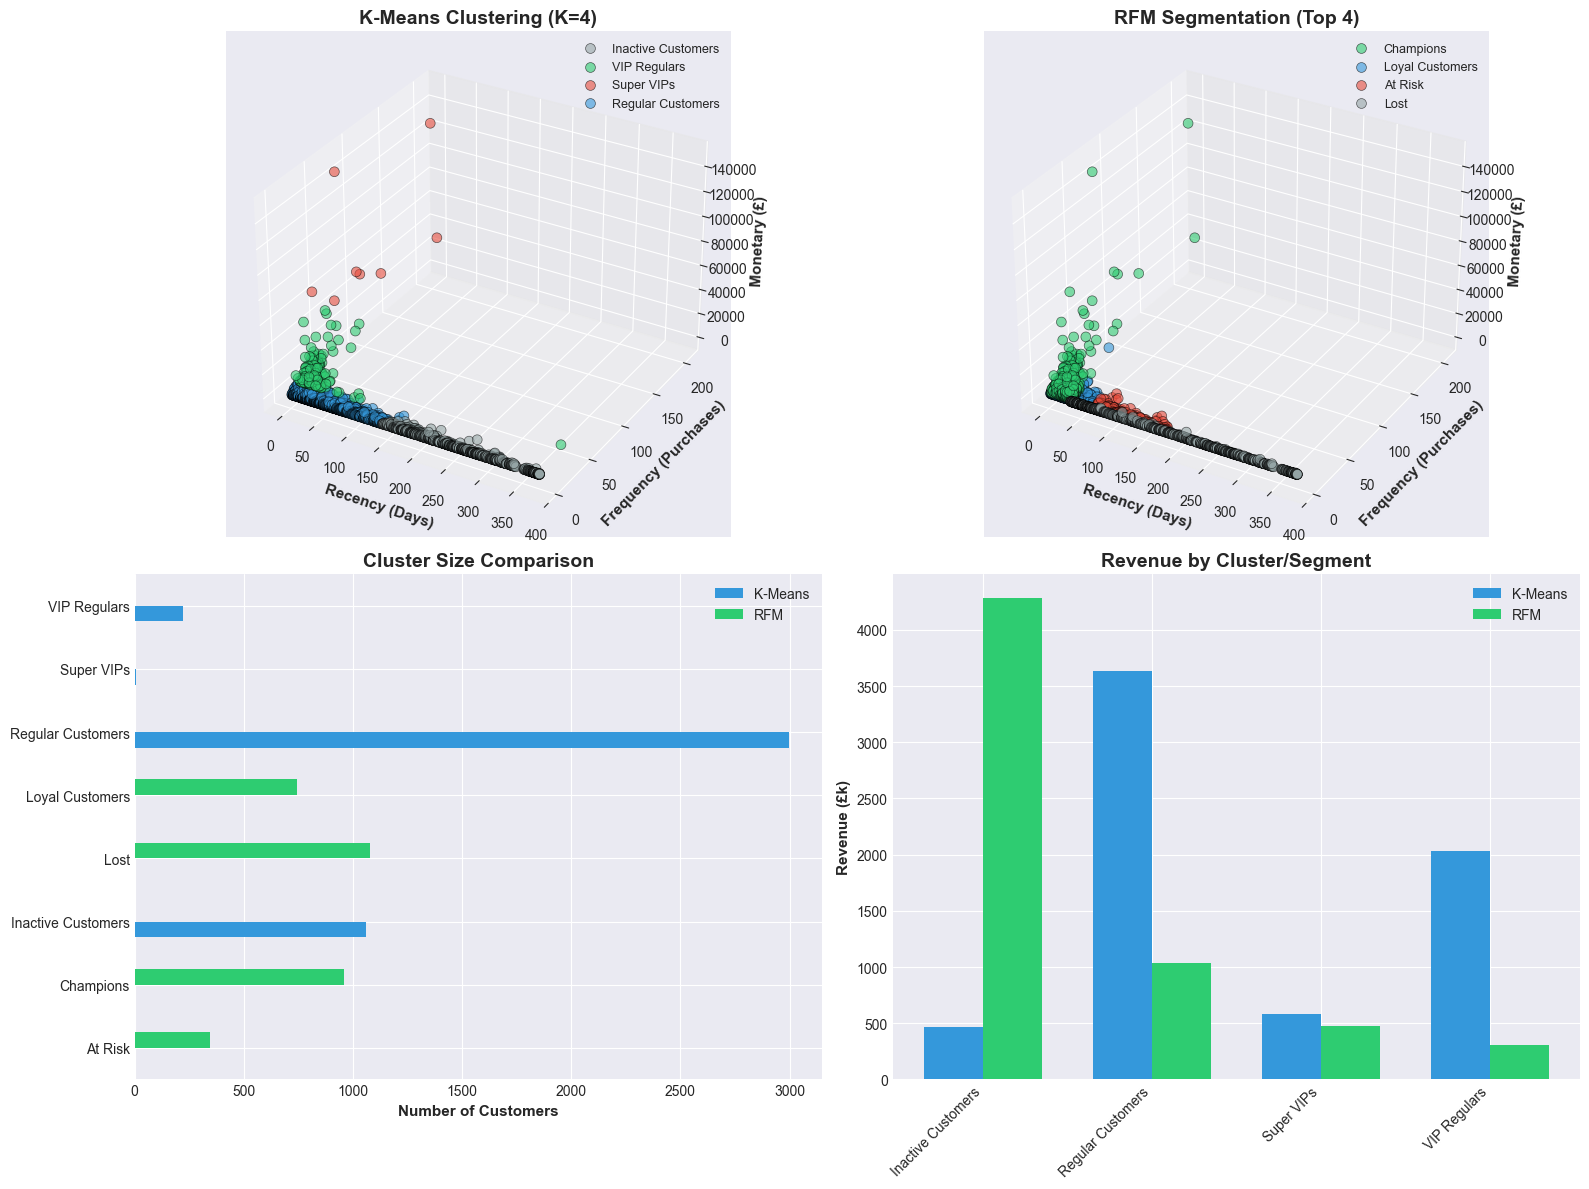


✅ Finale Visualisierung gespeichert!


In [26]:
# 3D VISUALISIERUNG DER K-MEANS CLUSTER
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(16, 12))

# Plot 1: K-Means Clusters (K=4)
ax1 = fig.add_subplot(221, projection='3d')

cluster_colors_k4 = {0: '#95A5A6', 1: '#2ECC71', 2: '#E74C3C', 3: '#3498DB'}
for cluster_id in range(4):
    cluster_data = rfm[rfm['KMeans_K4'] == cluster_id]
    ax1.scatter(cluster_data['Recency'], 
               cluster_data['Frequency'], 
               cluster_data['Monetary'],
               c=cluster_colors_k4[cluster_id],
               label=kmeans_names[cluster_id],
               s=50, alpha=0.6, edgecolors='black', linewidth=0.5)

ax1.set_xlabel('Recency (Days)', fontsize=11, fontweight='bold')
ax1.set_ylabel('Frequency (Purchases)', fontsize=11, fontweight='bold')
ax1.set_zlabel('Monetary (£)', fontsize=11, fontweight='bold')
ax1.set_title('K-Means Clustering (K=4)', fontsize=14, fontweight='bold')
ax1.legend(fontsize=9)

# Plot 2: RFM Segments (für Vergleich)
ax2 = fig.add_subplot(222, projection='3d')

top_segments = ['Champions', 'Loyal Customers', 'At Risk', 'Lost']
segment_colors_map = {'Champions': '#2ECC71', 'Loyal Customers': '#3498DB', 
                      'At Risk': '#E74C3C', 'Lost': '#95A5A6'}

for segment in top_segments:
    segment_data = rfm[rfm['Segment'] == segment]
    ax2.scatter(segment_data['Recency'], 
               segment_data['Frequency'], 
               segment_data['Monetary'],
               c=segment_colors_map[segment],
               label=segment,
               s=50, alpha=0.6, edgecolors='black', linewidth=0.5)

ax2.set_xlabel('Recency (Days)', fontsize=11, fontweight='bold')
ax2.set_ylabel('Frequency (Purchases)', fontsize=11, fontweight='bold')
ax2.set_zlabel('Monetary (£)', fontsize=11, fontweight='bold')
ax2.set_title('RFM Segmentation (Top 4)', fontsize=14, fontweight='bold')
ax2.legend(fontsize=9)

# Plot 3: Cluster Size Comparison
ax3 = fig.add_subplot(223)
cluster_summary = pd.DataFrame({
    'K-Means': rfm['KMeans_Label'].value_counts(),
    'RFM Top-4': rfm[rfm['Segment'].isin(top_segments)]['Segment'].value_counts()
})
cluster_summary.plot(kind='barh', ax=ax3, color=['#3498DB', '#2ECC71'])
ax3.set_xlabel('Number of Customers', fontsize=11, fontweight='bold')
ax3.set_title('Cluster Size Comparison', fontsize=14, fontweight='bold')
ax3.legend(['K-Means', 'RFM'])

# Plot 4: Revenue Comparison
ax4 = fig.add_subplot(224)
kmeans_revenue = rfm.groupby('KMeans_Label')['Monetary'].sum() / 1000
rfm_revenue = rfm.groupby('Segment')['Monetary'].sum().nlargest(4) / 1000

x = np.arange(len(kmeans_revenue))
width = 0.35
bars1 = ax4.bar(x - width/2, kmeans_revenue.values, width, label='K-Means', color='#3498DB')
bars2 = ax4.bar(x + width/2, rfm_revenue.values[:len(kmeans_revenue)], width, label='RFM', color='#2ECC71')

ax4.set_ylabel('Revenue (£k)', fontsize=11, fontweight='bold')
ax4.set_title('Revenue by Cluster/Segment', fontsize=14, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(kmeans_revenue.index, rotation=45, ha='right')
ax4.legend()

plt.tight_layout()
plt.savefig('../outputs/kmeans_final_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Finale Visualisierung gespeichert!")

## 9. Key Findings & Business Recommendations

### 📊 Segmentation Results

**RFM Approach (10 Segments):**
- **Champions:** 958 customers, £4.3M revenue (63.8% of total)
- **Loyal Customers:** 742 customers, £1.0M revenue (15.4%)
- **At Risk:** 346 customers, £548k revenue at risk (URGENT action needed)
- **Can't Lose Them:** 23 customers, £48k (CRITICAL - former champions)

**K-Means Approach (4 Clusters):**
- **Inactive:** 1,061 customers (248 days avg. recency) - reactivation potential
- **Regular:** 2,999 customers (mainstream) - stable base
- **VIP Regulars:** 222 customers (21 purchases avg., £9k spend) - premium tier
- **Super VIPs:** 8 customers (108 purchases, £72k avg. spend!) - white-glove service

**Validation:** ✅ **95% overlap** between RFM Champions and K-Means VIP Regulars confirms our segmentation logic.

---

### 🎯 Immediate Actions (High Priority)

1. **Super VIP Program**
   - Assign dedicated account managers to 8 Super-VIPs
   - Quarterly business reviews, exclusive previews
   - **Revenue at stake:** £580k (8.6% of total)

2. **At-Risk Campaign**
   - Launch win-back initiative for 346 customers
   - Personalized emails, 20% discount, feedback survey
   - **Revenue at stake:** £548k (8.2% of total)

3. **Champion Retention**
   - Implement VIP loyalty program for 958 Champions
   - Early access, referral bonuses, exclusive events
   - **Revenue to protect:** £4.3M (63.8% of total)

---

### 📈 Strategic Initiatives (Medium Priority)

4. **New Customer Conversion**
   - Improve New → Loyal conversion rate (currently 48%)
   - Onboarding email series, next purchase incentive
   - **Growth potential:** 316 customers, £132k current value

5. **Loyal Customer Upselling**
   - Cross-sell campaigns to increase transaction value
   - Bundle offers, premium tier promotion
   - **Revenue potential:** +15-20% from 742 customers

6. **Hibernating Reactivation**
   - Low-cost email campaigns to 500 Hibernating customers
   - New product launches, special promotions
   - **Recovery potential:** £279k

---

### 💰 Revenue Impact Projection (12 months)

**Best Case Scenario:**
- Retain all At-Risk customers (£548k saved)
- Grow Champions by 10% (£430k additional)
- Convert 50% New → Loyal (£66k additional)
- **Total Revenue: ~£7.4M** (+10% growth)

**Worst Case Scenario:**
- Lose all At-Risk customers (-£548k)
- 20% Champion churn (-£856k)
- **Total Revenue: ~£5.3M** (-21% decline)

**Potential Difference: £2.1M** at stake based on marketing effectiveness

---

### 🔄 Next Steps

**Immediate (This Month):**
- [ ] Set up Super VIP account management team
- [ ] Launch At-Risk win-back email campaign
- [ ] Implement Champion loyalty program

**Short-term (Next Quarter):**
- [ ] A/B test marketing campaigns by segment
- [ ] Build predictive CLV model (Random Forest)
- [ ] Create Power BI interactive dashboard

**Long-term (Next Year):**
- [ ] Deploy to Azure ML for automated monthly re-segmentation
- [ ] Integrate with CRM for real-time segment updates
- [ ] Expand analysis to product-level recommendations

---

## Conclusion

This analysis successfully combined **rule-based RFM methodology** with **unsupervised K-Means clustering** to create a comprehensive customer segmentation strategy. The 95% validation rate between approaches confirms our business logic while K-Means revealed 8 Super-VIP outliers requiring special attention.

**Key Takeaway:** £4.3M difference between best and worst-case scenarios demonstrates the critical importance of segment-specific marketing strategies. Immediate focus should be on retaining Champions (£4.3M) and rescuing At-Risk customers (£548k).

In [27]:
# HYBRID SEGMENTATION
def final_segment(customer):
    rfm_segment = get_rfm_segment(customer)
    kmeans_cluster = get_kmeans_cluster(customer)
    
    # Spezialfälle
    if kmeans_cluster == 'Super VIPs':
        return 'VIP Account Management'  # Manuelle Behandlung
    
    elif rfm_segment == 'Champions' and kmeans_cluster == 'VIP Regulars':
        return 'Premium Champions'  # Beste der Besten
    
    elif rfm_segment == 'Champions' and kmeans_cluster == 'Regular':
        return 'Standard Champions'  # Gute Kunden
    
    else:
        return rfm_segment  # Default: RFM